# Proyecto 1 - Minería de Datos

## Carga de Librerías


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


# Configuración de estilo para visualización


In [6]:
#sns.set_style("whitegrid")
train_df = pd.read_csv("train.csv")

## Carga de Datos


In [7]:
print("Información general del dataset:")
train_df.info()

print("\nResumen estadístico:")
print(train_df.describe())

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460

## Análisis de Valores Nulos


In [8]:
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\nValores nulos por columna:")
print(missing_values)


Valores nulos por columna:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


## Tratamiento de Valores Nulos


In [9]:
# Llenar valores nulos en variables categóricas con "None"
categorical_features = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
                        "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                        "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
# Llenar valores nulos en variables categóricas con "None"
train_df[categorical_features] = train_df[categorical_features].fillna("None")

numerical_features = ["LotFrontage", "GarageYrBlt", "MasVnrArea"]

# Llenar valores nulos en variables numéricas con la mediana
train_df[numerical_features] = train_df[numerical_features].apply(lambda x: x.fillna(x.median()))
    


## Transformación de Datos

In [10]:
# Aplicar logaritmo al precio de venta para normalizar
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

# Convertir variables categóricas en numéricas con Label Encoding de forma vectorizada
label_encoders = {col: LabelEncoder().fit(train_df[col]) for col in categorical_features}
train_df[categorical_features] = train_df[categorical_features].apply(lambda col: label_encoders[col.name].transform(col))


## Análisis de Correlación


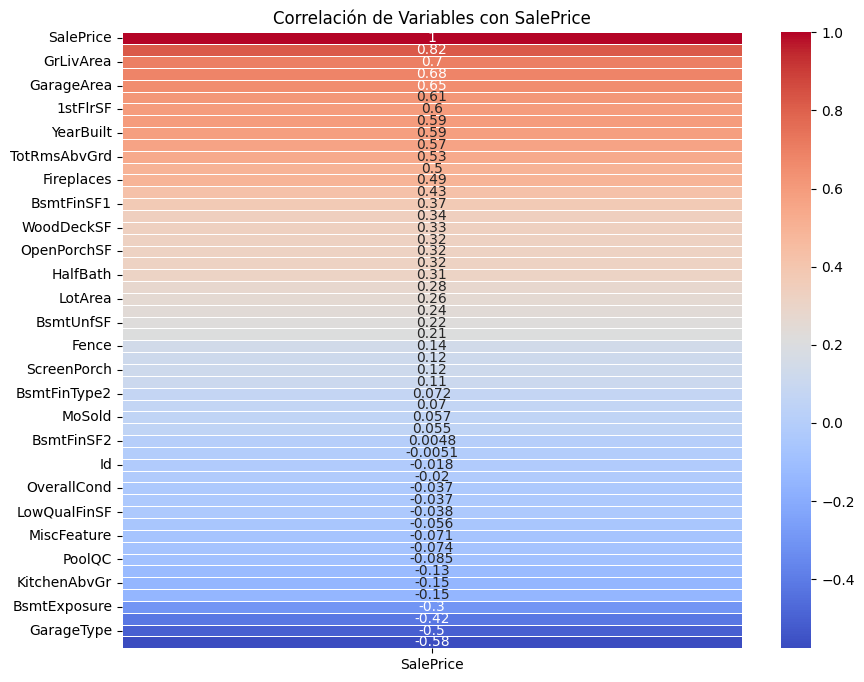

In [11]:
plt.figure(figsize=(10, 8))
corr_matrix = train_df.corr(numeric_only=True)
sns.heatmap(corr_matrix[['SalePrice']].sort_values(by='SalePrice', ascending=False), 
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlación de Variables con SalePrice")
plt.show()

In [12]:
correlation_threshold = 0.5
strong_corr_vars = corr_matrix["SalePrice"].abs().sort_values(ascending=False)
strong_corr_vars = strong_corr_vars[strong_corr_vars > correlation_threshold]
print("Variables con mayor correlación con SalePrice:")
print(strong_corr_vars)

Variables con mayor correlación con SalePrice:
SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
BsmtQual        0.576969
YearRemodAdd    0.565608
TotRmsAbvGrd    0.534422
GarageType      0.503129
Name: SalePrice, dtype: float64


## Análisis de Clustering (K-Means y DBSCAN)


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

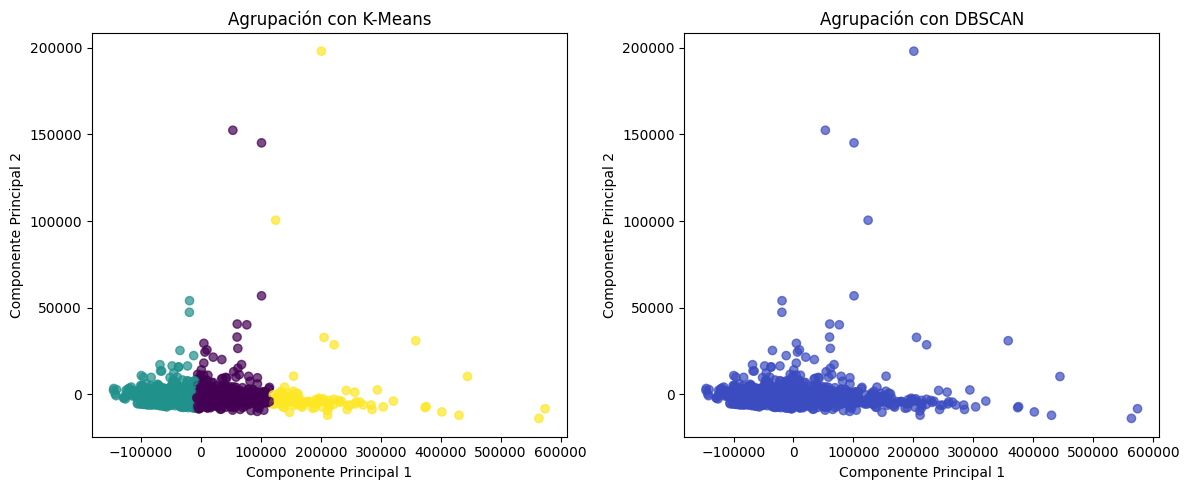

In [13]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt


# Carga del dataset
df = pd.read_csv("train.csv")  # Asegúrate de que el archivo "train.csv" está en la misma carpeta
print(df.head())  # Muestra las primeras filas para verificar que los datos están cargados


# Seleccionar variables relevantes para el clustering
features_for_clustering = df[['LotArea', 'GrLivArea', 'SalePrice']]

# Aplicar PCA para reducir la dimensionalidad y visualizar los datos
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_for_clustering)

# Aplicar K-Means con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(features_pca)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(features_pca)

# Visualización de Clustering con K-Means
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.7)
plt.title('Agrupación con K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Visualización de Clustering con DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters_dbscan, cmap='coolwarm', alpha=0.7)
plt.title('Agrupación con DBSCAN')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

plt.tight_layout()
plt.show()


## División de Datos en Entrenamiento y Prueba


In [14]:
X = train_df.drop(columns=["SalePrice", "Id"])
y = train_df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño de los conjuntos de datos:")
print(f"Entrenamiento: {X_train.shape}, Prueba: {X_test.shape}")



Tamaño de los conjuntos de datos:
Entrenamiento: (1168, 79), Prueba: (292, 79)


In [15]:
categorical_features = X_train.select_dtypes(include=['object']).columns

column_transformer = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)],
    remainder='passthrough' 
)

X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

print("Preprocesamiento completado")

Preprocesamiento completado


# Análisis de relaciones con la variable respuesta

### Análisis de Relación con Gráficos de Dispersión

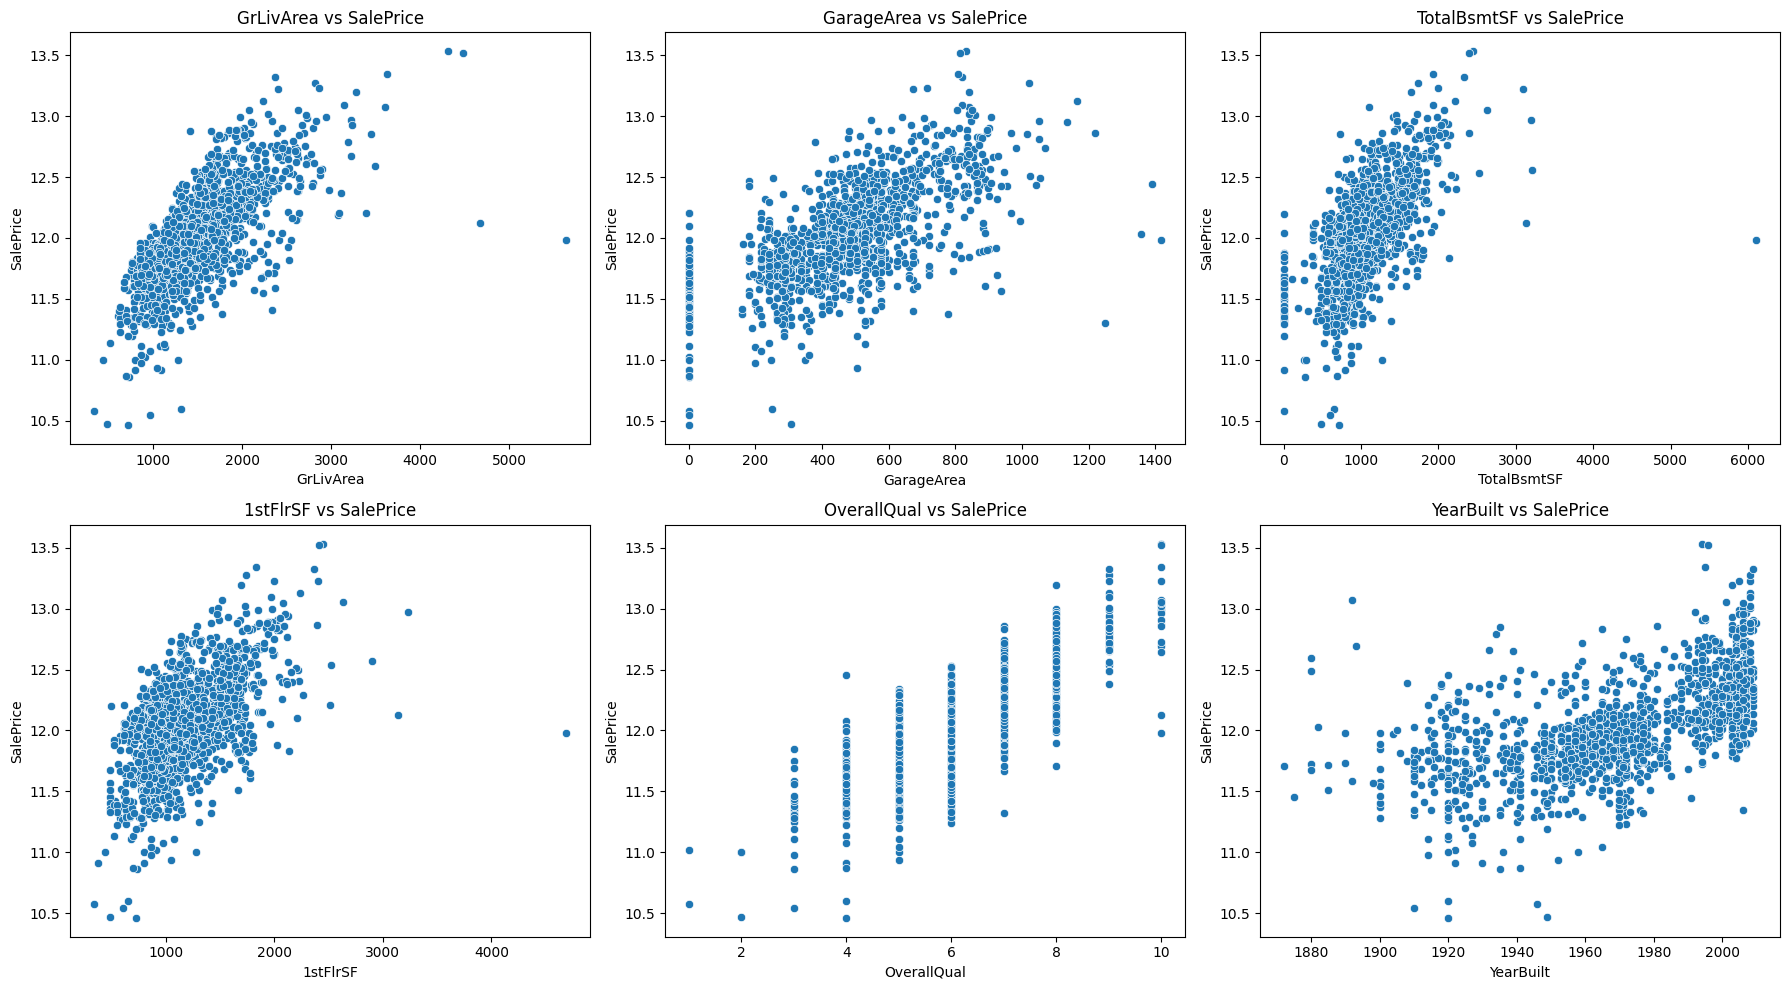

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Convierte la matriz de ejes en una lista

top_vars = ["GrLivArea", "GarageArea", "TotalBsmtSF", "1stFlrSF", "OverallQual", "YearBuilt"]

for var, ax in zip(top_vars, axes):
    sns.scatterplot(x=train_df[var], y=train_df["SalePrice"], ax=ax)
    ax.set_title(f"{var} vs SalePrice")

plt.tight_layout()
plt.show()


### Análisis de Relación con Boxplots

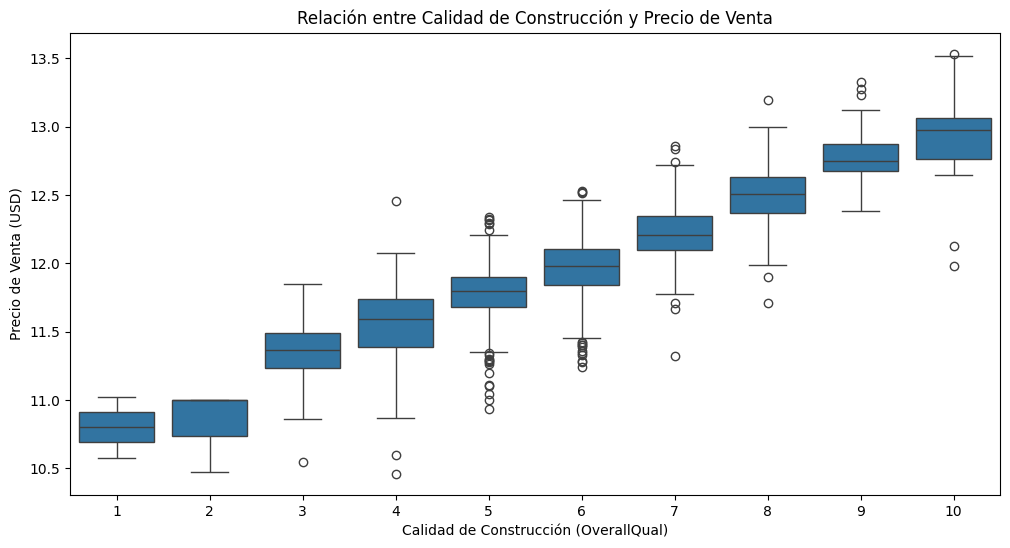

In [17]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=train_df["OverallQual"], y=train_df["SalePrice"])
plt.xlabel("Calidad de Construcción (OverallQual)")
plt.ylabel("Precio de Venta (USD)")
plt.title("Relación entre Calidad de Construcción y Precio de Venta")
plt.show()

### Regresión Lineal para evaluar impacto de variables

In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

# Separar variables numéricas y categóricas
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocesador: Escalar numéricas y transformar categóricas
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Crear pipeline con preprocesamiento y regresión lineal
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regression", LinearRegression())
])

# Entrenar modelo
pipeline.fit(X, y)

# Obtener coeficientes de regresión
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
coef_dict = dict(zip(feature_names, pipeline.named_steps["regression"].coef_))

# Imprimir coeficientes
print("\nCoeficientes de la regresión lineal:")
for var, coef in coef_dict.items():
    print(f"{var}: {coef:.2f}")



Coeficientes de la regresión lineal:
num__MSSubClass: -0.02
num__LotFrontage: 0.01
num__LotArea: 0.03
num__Alley: 0.00
num__OverallQual: 0.06
num__OverallCond: 0.04
num__YearBuilt: 0.05
num__YearRemodAdd: 0.02
num__MasVnrArea: 0.00
num__BsmtQual: -0.01
num__BsmtCond: 0.00
num__BsmtExposure: -0.01
num__BsmtFinType1: -0.00
num__BsmtFinSF1: 0.03
num__BsmtFinType2: 0.00
num__BsmtFinSF2: 0.01
num__BsmtUnfSF: -0.00
num__TotalBsmtSF: 0.03
num__1stFlrSF: 0.04
num__2ndFlrSF: 0.04
num__LowQualFinSF: 0.01
num__GrLivArea: 0.07
num__BsmtFullBath: 0.02
num__BsmtHalfBath: 0.00
num__FullBath: 0.01
num__HalfBath: 0.01
num__BedroomAbvGr: 0.00
num__KitchenAbvGr: -0.01
num__TotRmsAbvGrd: 0.01
num__Fireplaces: 0.01
num__FireplaceQu: 0.00
num__GarageType: -0.00
num__GarageYrBlt: -0.01
num__GarageFinish: -0.00
num__GarageCars: 0.01
num__GarageArea: 0.03
num__GarageQual: 0.00
num__GarageCond: 0.00
num__WoodDeckSF: 0.01
num__OpenPorchSF: 0.00
num__EnclosedPorch: 0.01
num__3SsnPorch: 0.00
num__ScreenPorch: 0.0

### Árbol de Decisión para relaciones no lineales

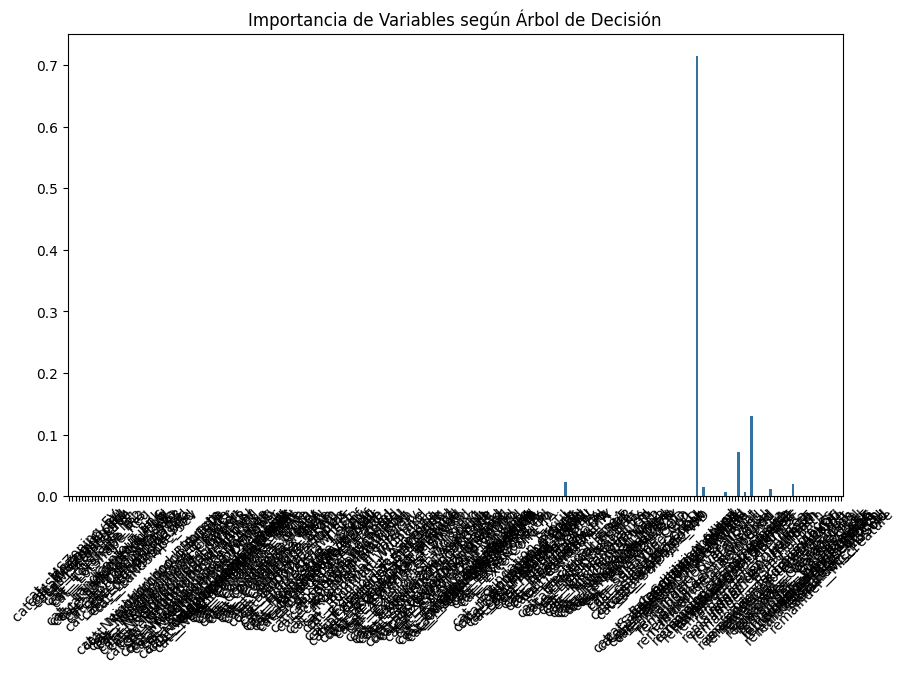

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# Separar variables numéricas y categóricas
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Aplicar OneHotEncoder a las variables categóricas
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
], remainder="passthrough")  # Mantener las variables numéricas sin cambios

# Transformar X para que todas las variables sean numéricas
X_transformed = preprocessor.fit_transform(X)

# Entrenar el Árbol de Decisión con las variables transformadas
tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X_transformed, y)

# Obtener nombres de las variables después del OneHotEncoder
feature_names = preprocessor.get_feature_names_out()

# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=tree.feature_importances_)
plt.xticks(rotation=45)
plt.title("Importancia de Variables según Árbol de Decisión")
plt.show()


In [20]:

# Importar librerías necesarias
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar el dataset
train_df = pd.read_csv("train.csv")

# Rellenar valores nulos en variables numéricas con la mediana
numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
train_df[numerical_features] = train_df[numerical_features].fillna(train_df[numerical_features].median())

# Excluir la variable objetivo "SalePrice" del análisis de VIF
numerical_features.remove("SalePrice")

# Calcular el Variance Inflation Factor (VIF) para cada variable numérica
X = train_df[numerical_features]
X = sm.add_constant(X)  # Agregar constante para el modelo

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Mostrar el análisis de multicolinealidad
display(vif_data)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, train_df["SalePrice"], test_size=0.2, random_state=42)

# Entrenar modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Predicciones en entrenamiento y prueba
y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)

# Calcular métricas de error
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Comparación de errores para detectar sobreajuste
error_comparison = pd.DataFrame({
    "Conjunto": ["Entrenamiento", "Prueba"],
    "RMSE": [train_rmse, test_rmse],
    "MAE": [train_mae, test_mae],
    "R²": [train_r2, test_r2]
})

display(error_comparison)

# Evaluación de modelos en el conjunto de prueba
modelo_arbol = DecisionTreeRegressor(random_state=42)
modelo_arbol.fit(X_train, y_train)
y_test_pred_arbol = modelo_arbol.predict(X_test)

# Comparación de modelos
model_comparison = pd.DataFrame({
    "Modelo": ["Regresión Lineal", "Árbol de Decisión"],
    "RMSE": [test_rmse, np.sqrt(mean_squared_error(y_test, y_test_pred_arbol))],
    "MAE": [test_mae, mean_absolute_error(y_test, y_test_pred_arbol)],
    "R²": [test_r2, r2_score(y_test, y_test_pred_arbol)]
})

display(model_comparison)

# Cargar el conjunto de datos de prueba
test_df = pd.read_csv("test.csv")

# Asegurar que todas las columnas de prueba coincidan con las de entrenamiento
X_final_test = test_df[numerical_features].fillna(train_df[numerical_features].median())

# Agregar la constante "const" como en el entrenamiento
X_final_test = sm.add_constant(X_final_test, has_constant="add")

# Realizar la predicción final
test_df["SalePrice_Predicted"] = modelo.predict(X_final_test)

# Guardar el resultado en un archivo CSV
test_df[["Id", "SalePrice_Predicted"]].to_csv("predicciones_finales.csv", index=False)

# Mostrar las primeras filas de las predicciones
display(test_df[["Id", "SalePrice_Predicted"]])



c:\Users\rodle\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,const,2.416497e+06
1,Id,1.026945e+00
2,MSSubClass,1.657272e+00
3,LotFrontage,1.568471e+00
4,LotArea,1.255983e+00
5,OverallQual,3.264369e+00
6,OverallCond,1.596944e+00
7,YearBuilt,5.008877e+00
8,YearRemodAdd,2.425908e+00
9,MasVnrArea,1.394015e+00


,Conjunto,RMSE,MAE,R²
0,Entrenamiento,33907.325191,21073.200082,0.807243
1,Prueba,36879.819322,23000.028866,0.822678


,Modelo,RMSE,MAE,R²
0,Regresión Lineal,36879.819322,23000.028866,0.822678
1,Árbol de Decisión,40272.116165,27587.554795,0.788556


,Id,SalePrice_Predicted
0,1461,114107.857536
1,1462,145821.139603
2,1463,171236.243060
3,1464,196886.739389
4,1465,195832.330468
...,...,...
1454,2915,53318.665620
1455,2916,62473.236437
1456,2917,161277.296022
1457,2918,92344.814687


# Segunda Entrega
### Librerías a utilizar

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### 1. Cargar el conjunto de datos

In [22]:
train_df = pd.read_csv("train.csv")

#### Preprocesamiento 

In [23]:
categorical_features = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
                          "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                          "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]

train_df[categorical_features] = train_df[categorical_features].fillna("None")

numerical_features = ["LotFrontage", "GarageYrBlt", "MasVnrArea"]
train_df[numerical_features] = train_df[numerical_features].apply(lambda x: x.fillna(x.median()))

# Transformar el precio de venta con logaritmo para normalizar la distribución
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

# Convertir variables categóricas a numéricas mediante Label Encoding
label_encoders = {col: LabelEncoder().fit(train_df[col]) for col in categorical_features}
train_df[categorical_features] = train_df[categorical_features].apply(lambda col: label_encoders[col.name].transform(col))


### 2. Separar el conjunto de datos en entrenamiento y prueba.

In [24]:
# Definimos X eliminando 'Id' y 'SalePrice'
X = train_df.drop(columns=["Id", "SalePrice"])
y = train_df["SalePrice"]

# Convertir todas las variables categóricas a variables dummy
X = pd.get_dummies(X, drop_first=True)

# Separar en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 3. Árbol de regresión

In [25]:
reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train, y_train)

# Usar el modelo para predecir en el conjunto de prueba
y_pred = reg_tree.predict(X_test)

# Evaluar el desempeño del modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Desempeño del árbol de regresión:")
print("RMSE:", rmse)
print("R²:", r2)

Desempeño del árbol de regresión:
RMSE: 0.1911380373110358
R²: 0.8042250910123396


### 4.Desarrollen, al menos, 3 modelos más, cambiando el parámetro de la profundidad del árbol.
¿Cuál es el mejor modelo para predecir el precio de las casas?

In [26]:
# Seleccionar las características y la variable objetivo
X = train_df.drop(columns=['SalePrice'])  # Variables predictoras
y = train_df['SalePrice']  # Variable objetivo

# Convertir variables categóricas en numéricas
X = pd.get_dummies(X)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Actividad 4: Entrenar árboles de regresión con diferentes profundidades
depths = [3, 6, 10]
models = {}
results = {}

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    models[depth] = model
    results[depth] = {'MAE': mae, 'MSE': mse, 'R2': r2}

# Seleccionar el mejor modelo basado en R2
best_depth = max(results, key=lambda d: results[d]['R2'])
best_model = models[best_depth]

print(f"Mejor profundidad: {best_depth}, R2: {results[best_depth]['R2']}")

Mejor profundidad: 10, R2: 0.7918606416521997


5. Comparen los resultados con el modelo de regresión lineal de la hoja anterior, ¿cuál lo hizo
mejor?

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

r2_lin = r2_score(y_test, y_pred_lin)
print(f"R2 de Regresión Lineal: {r2_lin}")
print(f"R2 del Mejor Árbol de Regresión (profundidad={best_depth}): {results[best_depth]['R2']}")

R2 de Regresión Lineal: 0.9131963705233905
R2 del Mejor Árbol de Regresión (profundidad=10): 0.7918606416521997


### 6.Dependiendo del análisis exploratorio elaborado creen una variable respuesta que les permita clasificar las casas en Económicas, Intermedias o Caras. Los límites de estas clases deben tener un fundamento en la distribución de los datos de precios, y estar bien explicados 

Distribución de categorías de precios:
Cara: 497 casas (34.0%)
Económica: 483 casas (33.1%)
Intermedia: 480 casas (32.9%)


C:\Users\rodle\AppData\Local\Temp\ipykernel_1488\613464264.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='PriceCategory', y='SalePrice', data=train_df,
C:\Users\rodle\AppData\Local\Temp\ipykernel_1488\613464264.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='PriceCategory', data=train_df,


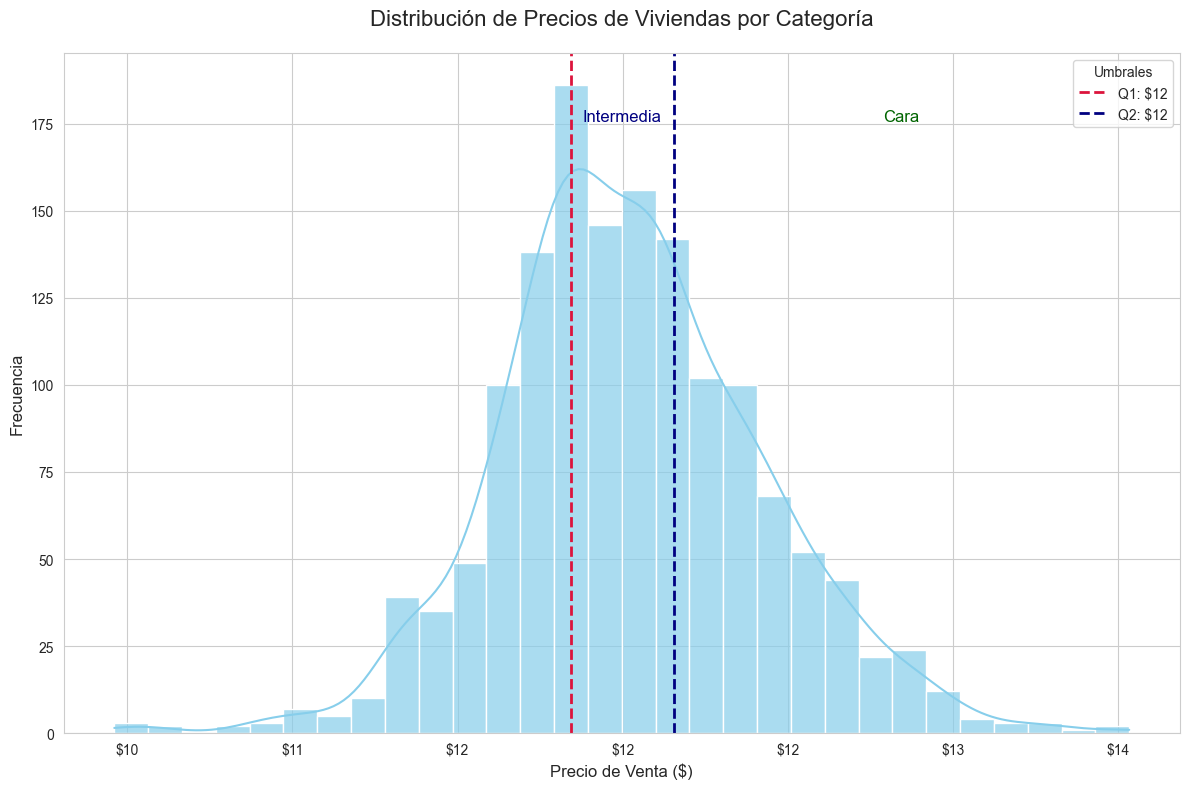

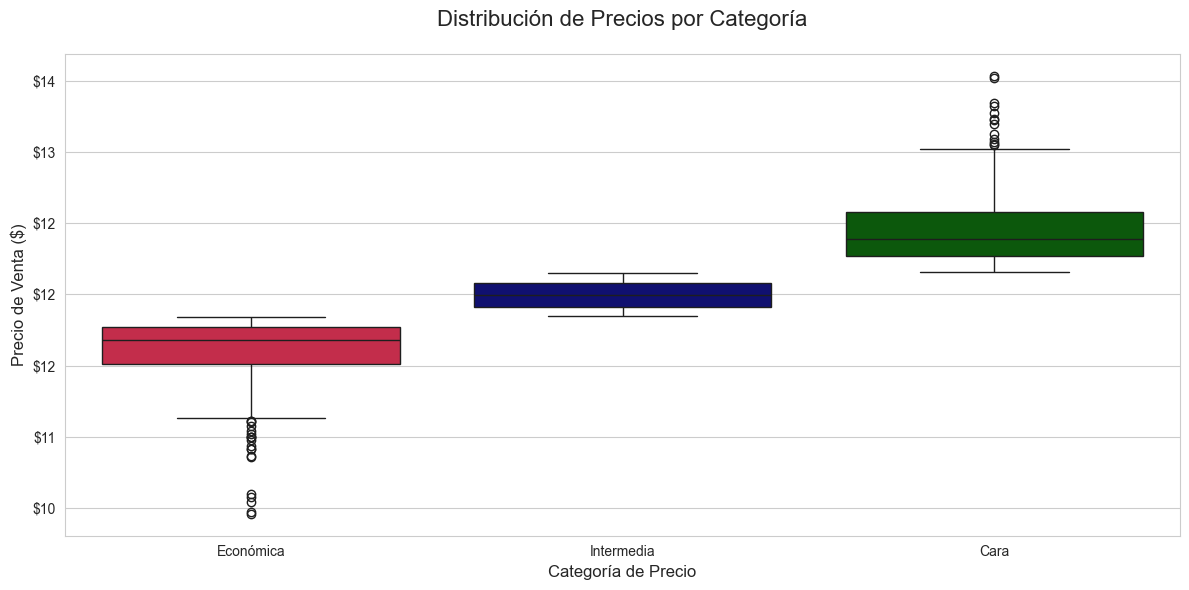

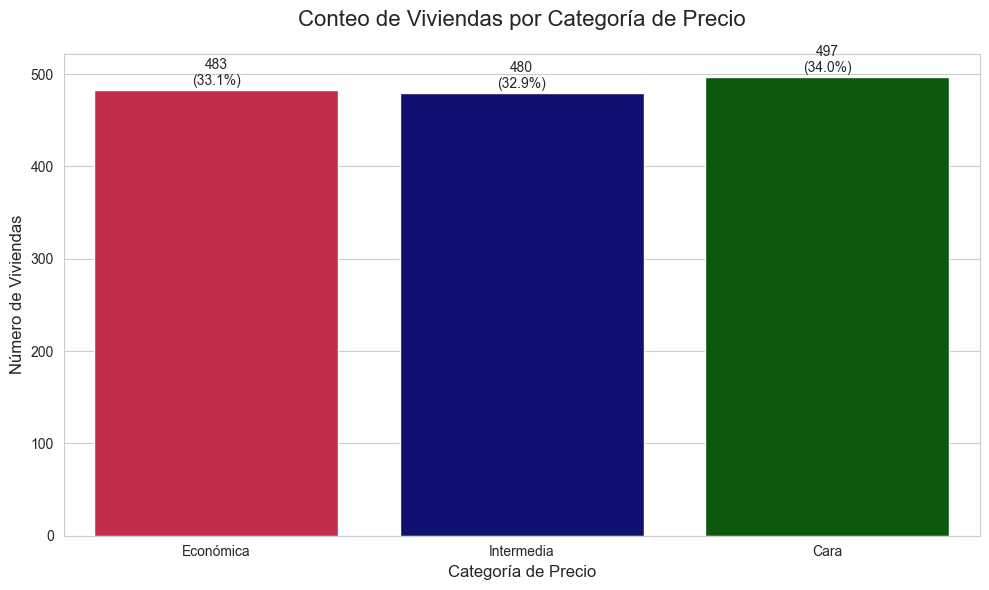

In [ ]:
from matplotlib.ticker import FuncFormatter


# Definir cuantiles para categorización
y = train_df['SalePrice']  # Asegúrate de que esta columna existe en tu DataFrame

# Definir cuantiles para categorización (usando numpy para mayor precisión)
q1 = np.percentile(y, 33)
q2 = np.percentile(y, 66)

def categorizar_precio(precio):
    if precio <= q1:
        return 'Económica'
    elif precio <= q2:
        return 'Intermedia'
    else:
        return 'Cara'

# Aplicar categorización
train_df['PriceCategory'] = train_df['SalePrice'].apply(categorizar_precio)

# Mostrar distribución de las categorías con porcentajes
category_counts = train_df['PriceCategory'].value_counts()
total = len(train_df)
print("Distribución de categorías de precios:")
for category, count in category_counts.items():
    percentage = count / total * 100
    print(f"{category}: {count} casas ({percentage:.1f}%)")

# Configurar el estilo de visualización
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Crear una visualización más informativa
# Histograma principal
ax = sns.histplot(train_df['SalePrice'], bins=30, kde=True, alpha=0.7, color='skyblue')

# Añadir líneas de cuantiles más visibles
plt.axvline(q1, color='crimson', linestyle='dashed', linewidth=2, label=f"Q1: ${q1:,.0f}")
plt.axvline(q2, color='navy', linestyle='dashed', linewidth=2, label=f"Q2: ${q2:,.0f}")

# Añadir etiquetas para cada categoría
plt.annotate('Económica', xy=(q1/2, ax.get_ylim()[1]*0.9), 
             ha='center', fontsize=12, color='crimson')
plt.annotate('Intermedia', xy=((q1+q2)/2, ax.get_ylim()[1]*0.9), 
             ha='center', fontsize=12, color='navy')
plt.annotate('Cara', xy=((q2+max(y))/2, ax.get_ylim()[1]*0.9), 
             ha='center', fontsize=12, color='darkgreen')

# Formatear eje X para mostrar precios en formato de moneda
def format_precio(x, pos):
    return f'${x:,.0f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_precio))

# Mejorar la apariencia general
plt.title("Distribución de Precios de Viviendas por Categoría", fontsize=16, pad=20)
plt.xlabel("Precio de Venta ($)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.legend(title="Umbrales", fontsize=10)
plt.tight_layout()

# Segunda visualización: boxplot por categoría
plt.figure(figsize=(12, 6))
sns.boxplot(x='PriceCategory', y='SalePrice', data=train_df, 
            order=['Económica', 'Intermedia', 'Cara'], 
            palette=['crimson', 'navy', 'darkgreen'])
plt.title("Distribución de Precios por Categoría", fontsize=16, pad=20)
plt.xlabel("Categoría de Precio", fontsize=12)
plt.ylabel("Precio de Venta ($)", fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_precio))
plt.tight_layout()

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='PriceCategory', data=train_df, 
              order=['Económica', 'Intermedia', 'Cara'],
              palette=['crimson', 'navy', 'darkgreen'])

# Añadir etiquetas con el conteo y porcentaje
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percentage = height / total * 100
    ax.text(p.get_x() + p.get_width()/2., height + 5,
            f'{int(height)}\n({percentage:.1f}%)',
            ha='center', fontsize=10)

plt.title("Conteo de Viviendas por Categoría de Precio", fontsize=16, pad=20)
plt.xlabel("Categoría de Precio", fontsize=12)
plt.ylabel("Número de Viviendas", fontsize=12)
plt.tight_layout()

# Mostrar todos los gráficos
plt.show()

### 7.Elaboren un árbol de clasificación utilizando la variable respuesta que crearon en el punto anterior. Expliquen los resultados a los que llegaron. Muestren el modelo gráficamente. Recuerden que la nueva variable respuesta es categórica, pero se generó a partir de los precios de las casas, no incluyan el precio de venta para entrenar el modelo.

C:\Users\rodle\AppData\Local\Temp\ipykernel_1488\1276373584.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_class[col].fillna(X_class[col].median(), inplace=True)
C:\Users\rodle\AppData\Local\Temp\ipykernel_1488\1276373584.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


Características seleccionadas (42 de 212):
1. Id
2. MSSubClass
3. LotFrontage
4. LotArea
5. OverallQual
6. OverallCond
7. YearBuilt
8. YearRemodAdd
9. MasVnrArea
10. BsmtQual
11. BsmtExposure
12. BsmtFinType1
13. BsmtFinSF1
14. BsmtUnfSF
15. TotalBsmtSF
16. 1stFlrSF
17. 2ndFlrSF
18. GrLivArea
19. FullBath
20. HalfBath
21. BedroomAbvGr
22. TotRmsAbvGrd
23. Fireplaces
24. FireplaceQu
25. GarageType
26. GarageYrBlt
27. GarageFinish
28. GarageCars
29. GarageArea
30. WoodDeckSF
31. OpenPorchSF
32. MoSold
33. YrSold
34. MSZoning_RL
35. MSZoning_RM
36. Exterior2nd_VinylSd
37. ExterQual_Gd
38. ExterQual_TA
39. Foundation_CBlock
40. Foundation_PConc
41. KitchenQual_Gd
42. KitchenQual_TA

Mejores parámetros: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5}
Mejor precisión en validación cruzada: 0.7646

Precisión en conjunto de prueba: 0.7945

Informe de clasificación:
              precision    recall  f1-score   support

   Económica       0.86      0.79      0.82        97
  Int

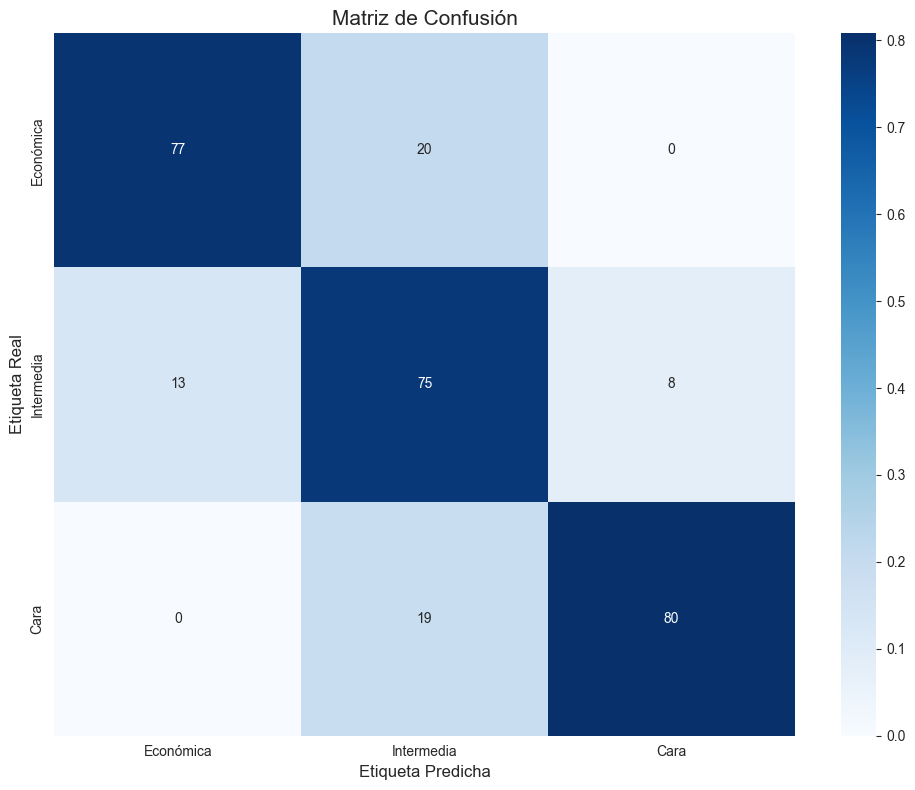

KeyError: 'label'

In [ ]:
# Importaciones necesarias (al principio del notebook)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib.ticker import FuncFormatter
import pydotplus

# Primero, debes cargar los datos
# Asegúrate de tener el archivo CSV o la fuente de datos correcta
# Ejemplo:
# train_df = pd.read_csv('house_prices_train.csv')

# Si no tienes el archivo, proporciona la ruta correcta a tus datos
# Por ejemplo:
# train_df = pd.read_csv('/ruta/a/tu/archivo.csv')

# PARTE 1: Categorización de precios
# Definir cuantiles para categorización
y = train_df['SalePrice']  # Asegúrate de que esta columna existe en tu DataFrame

# Definir cuantiles para categorización (usando numpy para mayor precisión)
q1 = np.percentile(y, 33)
q2 = np.percentile(y, 66)

def categorizar_precio(precio):
    if precio <= q1:
        return 'Económica'
    elif precio <= q2:
        return 'Intermedia'
    else:
        return 'Cara'

# Aplicar categorización
train_df['PriceCategory'] = train_df['SalePrice'].apply(categorizar_precio)

# Mostrar distribución de las categorías con porcentajes
category_counts = train_df['PriceCategory'].value_counts()
total = len(train_df)
print("Distribución de categorías de precios:")
for category, count in category_counts.items():
    percentage = count / total * 100
    print(f"{category}: {count} casas ({percentage:.1f}%)")

# Configurar el estilo de visualización
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Crear una visualización más informativa
# Histograma principal
ax = sns.histplot(train_df['SalePrice'], bins=30, kde=True, alpha=0.7, color='skyblue')

# Añadir líneas de cuantiles más visibles
plt.axvline(q1, color='crimson', linestyle='dashed', linewidth=2, label=f"Q1: ${q1:,.0f}")
plt.axvline(q2, color='navy', linestyle='dashed', linewidth=2, label=f"Q2: ${q2:,.0f}")

# Añadir etiquetas para cada categoría
plt.annotate('Económica', xy=(q1/2, ax.get_ylim()[1]*0.9), 
             ha='center', fontsize=12, color='crimson')
plt.annotate('Intermedia', xy=((q1+q2)/2, ax.get_ylim()[1]*0.9), 
             ha='center', fontsize=12, color='navy')
plt.annotate('Cara', xy=((q2+max(y))/2, ax.get_ylim()[1]*0.9), 
             ha='center', fontsize=12, color='darkgreen')

# Formatear eje X para mostrar precios en formato de moneda
def format_precio(x, pos):
    return f'${x:,.0f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_precio))

# Mejorar la apariencia general
plt.title("Distribución de Precios de Viviendas por Categoría", fontsize=16, pad=20)
plt.xlabel("Precio de Venta ($)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.legend(title="Umbrales", fontsize=10)
plt.tight_layout()

# Segunda visualización: boxplot por categoría
plt.figure(figsize=(12, 6))
sns.boxplot(x='PriceCategory', y='SalePrice', data=train_df, 
            order=['Económica', 'Intermedia', 'Cara'], 
            palette=['crimson', 'navy', 'darkgreen'])
plt.title("Distribución de Precios por Categoría", fontsize=16, pad=20)
plt.xlabel("Categoría de Precio", fontsize=12)
plt.ylabel("Precio de Venta ($)", fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_precio))
plt.tight_layout()

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='PriceCategory', data=train_df, 
              order=['Económica', 'Intermedia', 'Cara'],
              palette=['crimson', 'navy', 'darkgreen'])

# Añadir etiquetas con el conteo y porcentaje
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percentage = height / total * 100
    ax.text(p.get_x() + p.get_width()/2., height + 5,
            f'{int(height)}\n({percentage:.1f}%)',
            ha='center', fontsize=10)

plt.title("Conteo de Viviendas por Categoría de Precio", fontsize=16, pad=20)
plt.xlabel("Categoría de Precio", fontsize=12)
plt.ylabel("Número de Viviendas", fontsize=12)
plt.tight_layout()

# Mostrar todos los gráficos
plt.show()

# PARTE 2: Modelo de clasificación
# Convertir etiquetas categóricas a números
label_map = {'Económica': 0, 'Intermedia': 1, 'Cara': 2}
reverse_label_map = {0: 'Económica', 1: 'Intermedia', 2: 'Cara'}
train_df['PriceCategoryNum'] = train_df['PriceCategory'].map(label_map)

# Seleccionar las características y la variable objetivo
X_class = train_df.drop(columns=['SalePrice', 'PriceCategory', 'PriceCategoryNum'])

# Tratamiento mejorado de variables numéricas y categóricas
categorical_cols = X_class.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_class.select_dtypes(include=['int64', 'float64']).columns

# Imputar valores faltantes
for col in numerical_cols:
    X_class[col].fillna(X_class[col].median(), inplace=True)
    
for col in categorical_cols:
    X_class[col].fillna(X_class[col].mode()[0], inplace=True)

# Convertir variables categóricas en numéricas con manejo mejorado
X_class_encoded = pd.get_dummies(X_class, drop_first=True)  # drop_first reduce multicolinealidad

# Variable objetivo
y_class = train_df['PriceCategoryNum']

# Escalado de características numéricas para mejorar rendimiento
scaler = StandardScaler()
X_class_scaled = X_class_encoded.copy()
X_class_scaled[X_class_encoded.columns] = scaler.fit_transform(X_class_encoded)

# Dividir en conjunto de entrenamiento y prueba con estratificación para mantener distribución de clases
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Selección de características importantes
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
selector.fit(X_train_class, y_train_class)

# Obtener características importantes
selected_features = X_train_class.columns[selector.get_support()]
print(f"Características seleccionadas ({len(selected_features)} de {X_train_class.shape[1]}):")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

# Usar solo las características seleccionadas
X_train_selected = X_train_class[selected_features]
X_test_selected = X_test_class[selected_features]

# Optimización de hiperparámetros con validación cruzada
param_grid = {
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_selected, y_train_class)

# Mostrar mejores parámetros
print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Mejor precisión en validación cruzada: {grid_search.best_score_:.4f}")

# Obtener el mejor modelo
best_tree = grid_search.best_estimator_

# Evaluar en el conjunto de prueba
y_pred = best_tree.predict(X_test_selected)
accuracy = accuracy_score(y_test_class, y_pred)
print(f"\nPrecisión en conjunto de prueba: {accuracy:.4f}")

# Informe detallado de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test_class, y_pred, target_names=['Económica', 'Intermedia', 'Cara']))

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_class, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Crear matriz de confusión visual
ax = sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
                 xticklabels=['Económica', 'Intermedia', 'Cara'],
                 yticklabels=['Económica', 'Intermedia', 'Cara'])
plt.title('Matriz de Confusión', fontsize=15)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Exportar árbol a un archivo temporal para visualización más clara
dot_data = export_graphviz(
    best_tree,
    out_file=None,
    feature_names=selected_features,
    class_names=['Económica', 'Intermedia', 'Cara'],
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=3  # Limitar profundidad para mejor visualización
)

# Convertir a imagen
graph = pydotplus.graph_from_dot_data(dot_data)

# Colores personalizados para las clases
colors = ['#FF9999', '#99CCFF', '#99FF99']
nodes = graph.get_node_list()

for node in nodes:
    if node.get_name() not in ('node', 'edge'):
        attrs = node.get_attributes()
        if 'label' in attrs:
            values = attrs['label'].split('<br/>')
            for i, clazz in enumerate(['Económica', 'Intermedia', 'Cara']):
                if values and clazz in values[0]:
                    node.set_fillcolor(colors[i])

# Guardar y mostrar el árbol
graph.write_png('best_tree.png')

# Mostrar importancia de características
plt.figure(figsize=(12, 8))
importances = best_tree.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 características

plt.barh(range(len(indices)), importances[indices], color='skyblue')
plt.yticks(range(len(indices)), [selected_features[i] for i in indices])
plt.xlabel('Importancia Relativa')
plt.title('Top 15 Características Importantes')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Validación cruzada para evaluar estabilidad del modelo
cv_scores = cross_val_score(best_tree, X_class_scaled[selected_features], y_class, cv=5, scoring='accuracy')
print(f"\nPrecisión en validación cruzada: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Visualización del árbol completo (opcional si es demasiado grande)
plt.figure(figsize=(20, 15))
plot_tree(best_tree, filled=True, feature_names=list(selected_features), 
          class_names=['Económica', 'Intermedia', 'Cara'], fontsize=10)
plt.title("Árbol de Clasificación Óptimo para Categorías de Precios", fontsize=18)
plt.tight_layout()
plt.savefig('decision_tree_full.png', dpi=300, bbox_inches='tight')
plt.show()

# Predicciones en nuevos datos (ejemplo)
print("\nEjemplo de predicción:")
# Tomar 5 muestras aleatorias del conjunto de prueba
sample_indices = np.random.choice(X_test_selected.index, 5, replace=False)
X_samples = X_test_class.loc[sample_indices, selected_features]
y_samples_true = y_test_class.loc[sample_indices]
y_samples_pred = best_tree.predict(X_samples)

# Mostrar resultados
results_df = pd.DataFrame({
    'Predicción': [reverse_label_map[pred] for pred in y_samples_pred],
    'Valor Real': [reverse_label_map[true] for true in y_samples_true],
    'Coincide': y_samples_pred == y_samples_true
})
print(results_df)

# Mostrar probabilidades de predicción
y_probs = best_tree.predict_proba(X_test_selected)
probs_df = pd.DataFrame(y_probs, columns=['Prob. Económica', 'Prob. Intermedia', 'Prob. Cara'])
print("\nProbabilidades de las primeras 5 predicciones:")
print(probs_df.head())

### 8. Utilicen el modelo con el conjunto de prueba y determinen la eficiencia del algoritmo para clasificar.

In [ ]:
y_pred_class = clf.predict(X_test_class)
accuracy = accuracy_score(y_test_class, y_pred_class)

print(f"Exactitud del Árbol de Clasificación: {accuracy:.4f}")

Exactitud del Árbol de Clasificación: 0.8048


### 9.Realicen un análisis de la eficiencia del algoritmo usando una matriz de confusión para el árbol de clasificación. Tengan en cuenta la efectividad, dónde el algoritmo se equivocó más, dónde se equivocó menos y la importancia que tienen los errores.

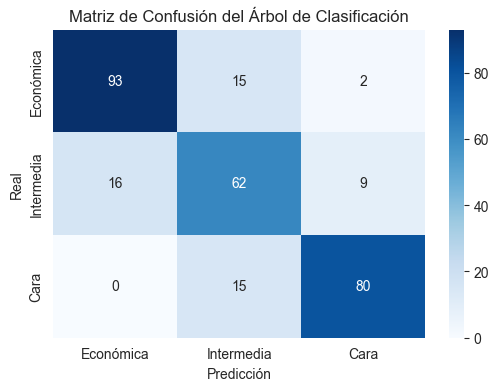


Reporte de Clasificación:
               precision    recall  f1-score   support

   Económica       0.85      0.85      0.85       110
  Intermedia       0.67      0.71      0.69        87
        Cara       0.88      0.84      0.86        95

    accuracy                           0.80       292
   macro avg       0.80      0.80      0.80       292
weighted avg       0.81      0.80      0.81       292



In [ ]:
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

# Mostrar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Económica', 'Intermedia', 'Cara'], 
            yticklabels=['Económica', 'Intermedia', 'Cara'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión del Árbol de Clasificación")
plt.show()

# Mostrar reporte de clasificación
print("\nReporte de Clasificación:\n", classification_report(y_test_class, y_pred_class, target_names=['Económica', 'Intermedia', 'Cara']))

### 10.Entrenen un modelo usando validación cruzada, predigan con él. ¿le fue mejor que al modelo anterior?

Primeras filas del dataset:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SaleP

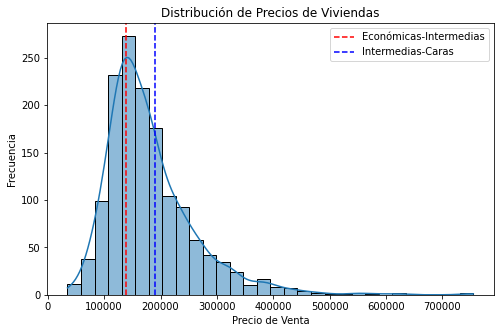

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

csv_path = "train.csv"  
train_df = pd.read_csv(csv_path)

print("Primeras filas del dataset:")
print(train_df.head())

q1 = train_df['SalePrice'].quantile(0.33)
q2 = train_df['SalePrice'].quantile(0.66)

def categorizar_precio(precio):
    if precio <= q1:
        return 'Económica'
    elif precio <= q2:
        return 'Intermedia'
    else:
        return 'Cara'

train_df['PriceCategory'] = train_df['SalePrice'].apply(categorizar_precio)

print("\nDistribución de categorías de precios:")
print(train_df['PriceCategory'].value_counts())

label_map = {'Económica': 0, 'Intermedia': 1, 'Cara': 2}
train_df['PriceCategoryNum'] = train_df['PriceCategory'].map(label_map)

X_class = train_df.drop(columns=['SalePrice', 'PriceCategory', 'PriceCategoryNum'])  # Variables predictoras
y_class = train_df['PriceCategoryNum']  # Variable objetivo categórica

X_class = pd.get_dummies(X_class)

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

clf_cv = DecisionTreeClassifier(max_depth=6, random_state=42)

cv_scores = cross_val_score(clf_cv, X_class, y_class, cv=5, scoring='accuracy')

print(f"\nExactitud promedio con validación cruzada: {cv_scores.mean():.4f}")
print(f"Desviación estándar de la validación cruzada: {cv_scores.std():.4f}")

plt.figure(figsize=(8, 5))
sns.histplot(train_df['SalePrice'], bins=30, kde=True)
plt.axvline(q1, color='r', linestyle='dashed', label="Económicas-Intermedias")
plt.axvline(q2, color='b', linestyle='dashed', label="Intermedias-Caras")
plt.legend()
plt.title("Distribución de Precios de Viviendas")
plt.xlabel("Precio de Venta")
plt.ylabel("Frecuencia")
plt.show()


### La validación cruzada redujo la exactitud.

### 11. Hagan al menos, 3 modelos más, cambiando la profundidad del árbol. ¿Cuál funcionó mejor?

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

depths = [3, 5, 7]
best_accuracy = 0
best_depth = None
results = {}

for depth in depths:
    clf_tuned = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf_tuned.fit(X_train_class, y_train_class)
    
    y_pred_tuned = clf_tuned.predict(X_test_class)
    
    acc = accuracy_score(y_test_class, y_pred_tuned)
    results[depth] = acc

    print(f"Profundidad {depth} - Exactitud: {acc:.4f}")

    if acc > best_accuracy:
        best_accuracy = acc
        best_depth = depth

print(f"\nLa mejor profundidad fue {best_depth} con una exactitud de {best_accuracy:.4f}")


Profundidad 3 - Exactitud: 0.7432
Profundidad 5 - Exactitud: 0.7911
Profundidad 7 - Exactitud: 0.7842

La mejor profundidad fue 5 con una exactitud de 0.7911


### Con max_depth=3, el modelo era muy simple y no capturaba bien la complejidad de los datos.
### Con max_depth=7, el modelo sobreajustó (memoriza demasiado los datos de entrenamiento).
### Con max_depth=5, logró el mejor equilibrio entre generalización y precisión.

### 12. Repitan los análisis usando Random Forest como algoritmo de predicción, expliquen sus resultados comparando ambos algoritmos.


Exactitud del Árbol de Decisión (max_depth=5): 0.7911
Exactitud de Random Forest (max_depth=5): 0.8082


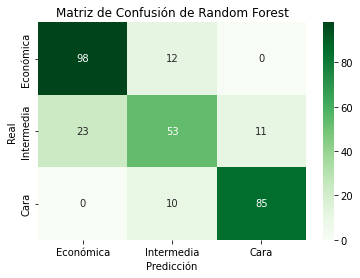


Reporte de Clasificación para Random Forest:

              precision    recall  f1-score   support

   Económica       0.81      0.89      0.85       110
  Intermedia       0.71      0.61      0.65        87
        Cara       0.89      0.89      0.89        95

    accuracy                           0.81       292
   macro avg       0.80      0.80      0.80       292
weighted avg       0.80      0.81      0.80       292



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train_class, y_train_class)

y_pred_rf = rf_model.predict(X_test_class)

rf_accuracy = accuracy_score(y_test_class, y_pred_rf)

print(f"\nExactitud del Árbol de Decisión (max_depth=5): {best_accuracy:.4f}")
print(f"Exactitud de Random Forest (max_depth=5): {rf_accuracy:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

rf_conf_matrix = confusion_matrix(y_test_class, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Económica', 'Intermedia', 'Cara'], 
            yticklabels=['Económica', 'Intermedia', 'Cara'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión de Random Forest")
plt.show()

print("\nReporte de Clasificación para Random Forest:\n")
print(classification_report(y_test_class, y_pred_rf, target_names=['Económica', 'Intermedia', 'Cara']))
